In [ ]:
# # Try one at a time

# 1. 
# from keras.models import load_model, save_model
# use save_model instead of model.save
# -- didn't work

# 2. 
# Check stack overflow = load using tf.keras
# -- fixed using this solution!!

# 3.
# optimizer = False maybe not

# 4.
# Check stackoverflow with import keras --> next solution

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals #to check for gpu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import pydicom
import cv2

# Batching for DataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence

# Keras and Tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Checking devices and system settings
import sys
print("Python: ", sys.version[:6])
print("Keras: ",keras.__version__)
print("Tensorflow: ",tf.__version__)
print("GPU Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nAll devices:", *tf.config.experimental.list_physical_devices(),sep="\n")

Python:  3.5.3 
Keras:  2.3.0
Tensorflow:  2.0.0
GPU Available:  True
Num GPUs Available:  1

All devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
# Set global variables
# un-comment as they are used
batch_size=100
# validation_ratio=0.1
# sample_size=2000
# epochs=3
# img_size=512
data_path = "../data/"   # used when calling DataGenerator
random_gen = np.random.RandomState(seed=12345)  # seed is not working

# dataset size to use during model building. Remove these later.
train_size = 128*8
valid_size = 128*2

In [15]:
def clean_data_csv(data_path, shuffle = True):
    from sklearn.utils import shuffle

    train_raw = pd.read_csv(data_path + 'stage_1_train.csv')
    train_raw['filename'] = train_raw['ID'].apply(lambda x: "ID_" + x.split('_')[1] + ".dcm")
    train_raw['type'] = train_raw['ID'].apply(lambda x: x.split('_')[2])

    # train_raw.reset_index(drop=True).head()

    train_pivot = train_raw[['Label', 'filename', 'type']].drop_duplicates().pivot(
        index='filename', columns='type', values='Label').reset_index()

    # train_pivot.head()
    
    if shuffle:
        train = shuffle(train_pivot)
    else:
        train = train_pivot
    train_sample2=train.reset_index(drop=True)
#     train_sample2.head()
    
    
    return train_sample2

    
    # not being used at present - seems not to work
    
    # create a new df for y_train to get out of pivot table format
    train = pd.DataFrame(
        train_pivot,columns=[
            'filename',
            'any',
            'epidural',
            'intraparenchymal',
            'intraventricular',
            'subarachnoid',
            'subdural'
        ])
    
    # # extract y_train (class vector)
    # y_train = x_y_train.iloc[:,1:].copy()

    # # extract x_train filenames
    # x_train_id = train.filename


In [16]:
# train_pivot.sum()
# extract y_train (class vector)
# x_y_train.iloc[:,1:].sum()

Some functions to extract the correct window-image. These have been adapted from https://www.kaggle.com/allunia/rsna-ih-detection-eda and references therin

DataGenerator class based on code written by https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.  The DataGenerator class inherits from the Keras utils.Sequence class and is used to read and serve the train data in batches.

In [17]:
# replicating a version that works
# can remove later

# from sklearn.utils import shuffle
# train = shuffle(train_pivot)
# train_sample=train
# train_sample2=train_sample.reset_index(drop=True)
# train_sample2.head()

train_sample2 = clean_data_csv(data_path = data_path, shuffle = True)

In [18]:
# valid=train_sample2
# valid=valid.reset_index(drop=True)
# valid.head()

In [19]:
train_sample2['any'].value_counts(normalize=True)

0    0.855985
1    0.144015
Name: any, dtype: float64

In [20]:
# valid['any'].value_counts(normalize=True)

In [21]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [22]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs_labels, data_path = '', batch_size=128, dim=(512,512)):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs_labels
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs['filename'][k] for k in indexes]
        list_label_temp=[[int(self.list_IDs['any'][i]),int(self.list_IDs['epidural'][i]),int(self.list_IDs['intraparenchymal'][i]),int(self.list_IDs['intraventricular'][i]),int(self.list_IDs['subarachnoid'][i]),int(self.list_IDs['subdural'][i])] for i in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp,list_label_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp,list_label_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            ds=pydicom.dcmread(self.data_path+'stage_1_train_images/' +list_IDs_temp[i] )
            temp=ds.pixel_array
            window_center , window_width, intercept, slope = get_windowing(ds)
            img = window_image(temp, 50, 100, intercept, slope)
            resized = cv2.resize(img, (200, 200))
            X.append(resized)       
        X=np.array(X).reshape(-1,200,200,1)
        y_train=np.asarray(list_label_temp) 
        return X,y_train

In [25]:
traingen_data = train_sample2[0 : train_size].reset_index(drop=True)
validgen_data = train_sample2[train_size + 1 : train_size + valid_size].reset_index(drop=True)

In [27]:
traingen=DataGenerator(traingen_data,data_path = data_path, batch_size = 128)#increase back to 100000
validgen=DataGenerator(validgen_data,data_path = data_path, batch_size = 128)

# traingen=DataGenerator(train_sample2[0 : train_size].reset_index(drop=True),data_path = data_path, batch_size = 128)#increase back to 100000
# validgen=DataGenerator(train_sample2[train_size + 1 : train_size + valid_size].reset_index(drop=True),data_path = data_path, batch_size = 128)

In [29]:

# Disabled for the moment - later re-enable
# train_actual = train[0:train_size]
# train_valid = train[train_size:(train_size+valid_size)]

# traingen=DataGenerator(train_actual,data_path = data_path, batch_size=batch_size) #increase back to 100000
# validgen=DataGenerator(train_valid,data_path = data_path, batch_size=batch_size)

For an unbalanced data-set it is good to define a custom loss function like the focal loss. We will borrowed the code for this from https://www.kaggle.com/xhlulu/rsna-intracranial-simple-densenet-in-keras

In [30]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

In [31]:
def save_model(model, model_tags = [],return_df=False, model_notes = ""):
    """
    Save model in the designated root folder
    Add a row to the model_records.csv with information about the current training run
    Keyword arguments:
    model -- keras model
    """
    
    # get the current time
    from datetime import datetime
    d = datetime.utcnow()
    timestamp = d
    time_name = d.strftime("%Y-%m-%dT%H%M%S")

    # set folder paths and other saving specs
    root = 'models/'
    save_as_type = 'h5' # can choose 'h5' or 'tf'
    model_records_path = root+'model_records.csv'
    model_name = time_name+'_model'+'.'+save_as_type
    model_path = root+model_name
    
    # model attributes
    train_size = 1
    validation_size = 1    
    #     train_data_class_imbalance = 
    epochs = 1
    optimizer = 1
    layers = []
    num_layers = len(layers)

    # create a unique set of tags, include tensorflow and keras
    model_tags = set([x.lower() for x in model_tags + ['tensorflow','keras']])

    # model effectiveness    
    score = 1
    
    # training information
    total_time = 1
    
    data = {
    # general
        'timestamp': [timestamp],
        'model_notes': [model_notes],
    # model attributes
        'train_size': [train_size],
        'validation_size': [validation_size],
        'epochs': [epochs],
        'optimizer': [optimizer],
        'num_layers': [num_layers],
        'model_tags': [model_tags],
        'layers': [layers],
    # model effectiveness
#         'loss': [loss],
        # added below
        'score': [score],
    # training specification
    # saving information
        'model_name': [model_name],
        'model_path': [model_path]
    }

#     for attribute in model.metrics_names:
#         try:
#             data[attribute] = model[attribute]
#         except:
#             print("model."+attribute+" is not a valid parameter")
    
    # save the data to a dictionary
    temp_df = pd.DataFrame.from_dict(data)
    
    # attempt to amend the previous csv. If not available, create a new one
    try:
        df = pd.read_csv(model_records_path)
        df = pd.concat([df,temp_df],sort=False)
    except:
        df = temp_df
    finally:
        df.reset_index(drop=True,inplace=True)
    
    # save df to csv
    df.to_csv(model_records_path,index=False)

    
    # trying with save_model instead of model.save
    keras.models.save_model(model, model_path)
    
    # save model
#     model.save(model_path)
#     model.save(
#         model_path,
#         overwrite=True,
#         include_optimizer=True,
#         save_format='h5',
#         signatures=None,
#         options=None,
#     )
    
    if return_df:
        return df

In [32]:
model_notes = "test run with ~1000 images and ~200 valid size , using save_model(path)"
model_tags = ['test']

In [33]:
traingen

In [34]:
validgen

Now that we have both Input=X , Category=y_trest we can train a basic barebones model.
Here we have a model which is like ==   CNN -> CNN->  Flatten --> Dense ---> Dense(output)

In [59]:
# RUN MODEL - RUN ONLY WHEN READY OR SKIP TO LOAD MODEL


# enter any notes that you want stored with this model
model_notes = model_notes
model_tags = model_tags

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(200, 200,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5,5)))

model.add(Flatten())  

# model.add(Dense(100))
# model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.compile(loss=focal_loss,
#                optimizer='adam',
#                metrics=['accuracy'])

# model.fit(X,y_train,batch_size=32,epochs=6,validation_split=0.5)
history=model.fit_generator(
    generator=traingen,
    validation_data=validgen,
    use_multiprocessing=True,
    workers=5,
    epochs=2)

# save_model(model, return_df=False, model_notes=model_notes)


Epoch 1/2
8/8 [==============================] - 4s 545ms/step - loss: 0.5852 - accuracy: 0.8750 - val_loss: 0.9154 - val_accuracy: 1.0000
Epoch 2/2
8/8 [==============================] - 3s 394ms/step - loss: 0.5481 - accuracy: 1.0000 - val_loss: 0.8980 - val_accuracy: 1.0000


In [51]:


model_path = 'models/test_123.h5'
keras.models.save_model(model, model_path)
loaded_model = tf.keras.models.load_model(model_path)


In [71]:
type(history)

tensorflow.python.keras.callbacks.History

In [53]:
loaded_model

In [416]:
def load_model(root = 'models/', records_output = True, model_output = False, model_file_path = ""):
    """
    
    
    """
    model_records_path = root+'model_records.csv'
    df = pd.read_csv(model_records_path)
    if not model_output:
        return df
    else:
        
        model = keras.models.load_model(model_file_path)
        if records_output:
            return df, model
        else:
            return model

In [420]:
# load_model()

records, model = load_model(records_output = True, model_output = True, model_file_path = "models/2019-10-11T161725_model.h5")
records.tail(10)

ValueError: Unknown initializer: GlorotUniform

In [397]:
# Load model, if starting from a pre-made model
# root = 'models/'
# records_df, model = load_model(model_file_path="models/2019-10-11T004440_model.h5", model_output=True)

# from keras.initializers import glorot_uniform

from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        keras.models.load_model('models/2019-10-11T004440_model.h5')

# model = keras.models.load_model('models/2019-10-11T004440_model.h5',custom_objects={"GlorotUniform": keras.initializers.glorot_uniform})

# custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform}

# from keras.models import load_model
# from keras.utils import CustomObjectScope

# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

#         model = load_model('imdb_mlp_model.h5')

# root = 'models/'

# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df


ValueError: Unknown initializer: GlorotUniform

AttributeError: 'Sequential' object has no attribute 'history'

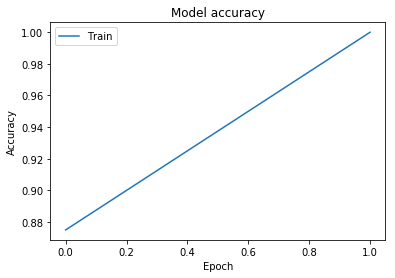

In [63]:
# plot accuracy

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

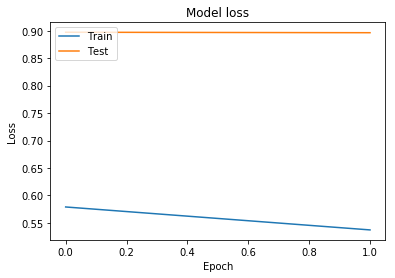

In [47]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [319]:
# model.metrics_names

In [ ]:
# end model - start test code

In [160]:
model_tags = ['abc']
model_tags = model_tags + ['hello','hello2']
model_tags

['abc', 'hello', 'hello2']

In [318]:
test = save_model(model, model_tags = [],return_df=True, model_notes="hello")
test

worked-1
worked-2


,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T211053_model.h5,NaN,models/2019-10-10T211053_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:53.796514,1,1
1,1,[],2019-10-10T211056_model.h5,NaN,models/2019-10-10T211056_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:56.404866,1,1
2,1,[],2019-10-10T211112_model.h5,hello,models/2019-10-10T211112_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:12.708478,1,1
3,1,[],2019-10-10T211115_model.h5,hello,models/2019-10-10T211115_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:15.211067,1,1
4,1,[],2019-10-10T211116_model.h5,hello,models/2019-10-10T211116_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:16.248314,1,1
5,1,[],2019-10-10T211129_model.h5,hello,models/2019-10-10T211129_model.h5,"{keras, tensorflow}",0,1,1,2019-10-10 21:11:29.360498,1,1


In [286]:
root = 'models/'
save_as_type = 'h5' # can choose 'h5' or 'tf'
model_records_path = root+'model_records.csv'

df = pd.read_csv(model_records_path)
df

,epochs,layers,model_name,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T202614_model.h5,models/2019-10-10T202614_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:14.109413,1,1
1,1,[],2019-10-10T202617_model.h5,models/2019-10-10T202617_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:17.506235,1,1
2,1,[],2019-10-10T202618_model.h5,models/2019-10-10T202618_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:18.759291,1,1
3,1,[],2019-10-10T202619_model.h5,models/2019-10-10T202619_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:19.641559,1,1
4,1,[],2019-10-10T202620_model.h5,models/2019-10-10T202620_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:20.819121,1,1
5,1,[],2019-10-10T202621_model.h5,models/2019-10-10T202621_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:21.808913,1,1
6,1,[],2019-10-10T202622_model.h5,models/2019-10-10T202622_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:22.799794,1,1
7,1,[],2019-10-10T202627_model.h5,models/2019-10-10T202627_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:27.330631,1,1


In [112]:
import time
# import datetime
from datetime import datetime

In [194]:
# d = date.today()
from datetime import datetime
d = datetime.utcnow()
d.isoformat()
d.strftime("%Y-%m-%dT%H%M%S")

'2019-10-10T195147'

In [ ]:
y_pred = model.predict()

In [211]:

model_tags = []
model_tags = set(
    [
        x.lower() 
        for x 
        in model_tags.extend(['tensorflow','keras'])
    ]
)


TypeError: 'NoneType' object is not iterable

In [121]:
d.isoformat()

'2019-10-10T17:50:33.323950'

In [114]:
d.isoformat()+d.hour()

TypeError: 'int' object is not callable

In [128]:
[x.lower for x in ['Adsf',]]

['adsf', 'adf']

In [ ]:
dicti = {}
pd.from_dic